# Определение стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

 1. качество предсказания;  
 2. скорость предсказания;
 3. время обучения.

# 1. Подготовка данных

# 1.1. Анализ данных

In [2]:
#импорт  стандартных библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from numpy.random import RandomState
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import time 
from sklearn.metrics import mean_squared_error as mse 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, mean_squared_error 
from numpy import mean
from numpy import absolute
from numpy import sqrt

In [3]:
#импорт сторонних библиотек
!pip install phik
from phik import report
from phik.report import plot_correlation_matrix
!pip install catboost
!pip install lightgbm
!pip install xgboost
import catboost
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
!pip install category_encoders
from category_encoders.target_encoder import TargetEncoder

In [4]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

In [5]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
print('Количество пропущенных значений в таблице:', data.isnull().sum().sum ())

Количество пропущенных значений в таблице: 181077


In [8]:
pd.DataFrame(data.isna().sum(), columns = ['пропуски']).style.background_gradient('coolwarm')

,пропуски
DateCrawled,0
Price,0
VehicleType,37490
RegistrationYear,0
Gearbox,19833
Power,0
Model,19705
Kilometer,0
RegistrationMonth,0
FuelType,32895


In [9]:
print(data.shape)

(354369, 16)


In [10]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [11]:
print('Количество дубликатов значений  в таблице:' , data.duplicated().sum())

Количество дубликатов значений  в таблице: 4


Датасет состоит из 14 столбцов.(Признаки) Из них 'Price' является целевым признаком типа данных 'int64'. В соответсвии с информацией о датасете'DateCrawled','VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'DateCreated', 'LastSeen' являются типом данных object. 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode' - тип данных целочисленный. Пропуски в данных с типом данных 'object'. Количество дубликатов 4. Количество пропусков 181077

# 1.2. Предподготовка данных перед делением на выборки

В этом пункте проекта я рассмотрю каждый признак отдельно и произведу подготовку данных перед делением на выборки: очистить датасет от выбросов, аномальных значений и т.д.

In [ ]:
#data['DateCrawled'].unique() 

In [ ]:
#data['DateCreated'].unique() 

Больших временных ограничений по дате скачивания анкеты из базы дата создания анкеты не имеет больших временных границ. Все анкета скачивались и загружались в течении 2016-2015 гг. Поэтому я считаю, что данные столбцы необходимо удалить для более быстрого и эффективного подбора гиперпараметров для моделей МО, в том числе градиентного бустинга.


In [12]:
#произведу замену пропусков в категориальных признаках заглушкой 'unknown' так как не все модели с бустингами будут работать с пропусками
data = data.fillna('unknown') 

рименение восстановления категориальных признаков в данном случае считаю некорректным так как:
       
    1. Признак 'Repaired' так как точно или ближе к точному невозможно узнать была ли машина в ремонте. Есть некая зависимость от того, что чем машина новее, тем больше вероятность, что она не была в ремонте. Но это лишь вероятность. А какова погрешность этой вероятности? Насколько она точная. Код представлен ниже. Например, среди новых автомобилей старше 2012 года, были в ремонте 12.8 %. 19,6% были в ремонте среди автомобилей с 2000 по 2012 год. 14,2 % среди супер ретро не были в ремонте. Автомобили просто ретро не представлены.
       
    2. Признаки, где есть значение other ('другие'). По моему мнению, другие означают другие, например модели автомобилей, кроме тех, что представлены в списке уникальных значений. Если поместить все пропуски например модельного ряда с пропусками, вероятность того, что попадут модели уже известны очень большая. А пропусков в категориальных признаках очень много. Поэтому исходя из всего вышесказанного, я решила применить заглушку 'unknown', для наиболее точного заполнения пропущенных значений.

In [ ]:
#данные загружены после удаления аномалий в столбце о дате регистрации и применения заглушки
#def Age_auto(row):
    #RegistrationYear = row['RegistrationYear']
    #if RegistrationYear <= 1980:
        #return 'Супер ретро'
    #if 1980 > RegistrationYear <= 2000:
        #return 'Ретро'
    #if 2000 > RegistrationYear <= 2012:
        #return 'Старые автомобили'
    #if RegistrationYear > 2012:
        #return 'Новые автомобили'
#data['AgeType'] = data.apply(Age_auto, axis=1)
#s = data.groupby(['Repaired' , 'AgeType']).agg(data=('AgeType', 'count'))
#print(s)  

#данные закомментила, чтобы не перегружать датасет лишними столбцами. 

In [13]:
#удаление неиформативных столбцов
data.drop(columns=['NumberOfPictures', 'LastSeen', 'PostalCode', 'DateCreated', 'DateCrawled', 'RegistrationMonth'], inplace=True) 

In [14]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Среди значений столбца о регистрации автомобиля, есть аномальные значения. Проверю количество аномальных значений по отношению ко всему датасету, если оно небольшое, то произведу удаление аномальных значений. Если аномальных значений большое количество, то я заменю на другое значение.


In [15]:
data = data.query('RegistrationYear >= 1950 & RegistrationYear < 2017')
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970, 1965, 1974,
       1979, 1955, 1978, 1972, 1968, 1977, 1961, 1960, 1966, 1975, 1963,
       1964, 1954, 1958, 1967, 1959, 1956, 1962, 1957, 1951, 1953, 1950,
       1952], dtype=int64)

In [16]:
print('Число аномально высоких значений в признаке "Power":', len(data[data['Power'] > 500]))
data = data[data['Power'] < 500]

Число аномально высоких значений в признаке "Power": 418


In [17]:
data.loc[data['Power'] < 5, 'Power'] = float('nan')
data['Power'] = data['Power'].fillna(data.groupby(["Brand", "Model"])['Power'].transform("median"))
unknown =  data['Power'].mean()
data['Power'] = data['Power'].fillna(unknown)
data['Power'] = data['Power'].astype('int64')

In [18]:
data = data.query('Price > 100')

In [ ]:
#data['Price'].min()

In [ ]:
#data['Power'].max()

In [ ]:
#data['Power'].min()

Были удалены аномалии в значениях мощности и стоимости. В значениях мощности удалены значеyия более 500 л.с. Значения мощности, менее 5 л.с. были заменены на медианну по модели и бренду. Также удалены аномалии в таргете(менее 100 евро)


# 1.3 Исследовательский анализ категориальных признаков

Text(0, 0.5, 'Стоимость автомобиля')

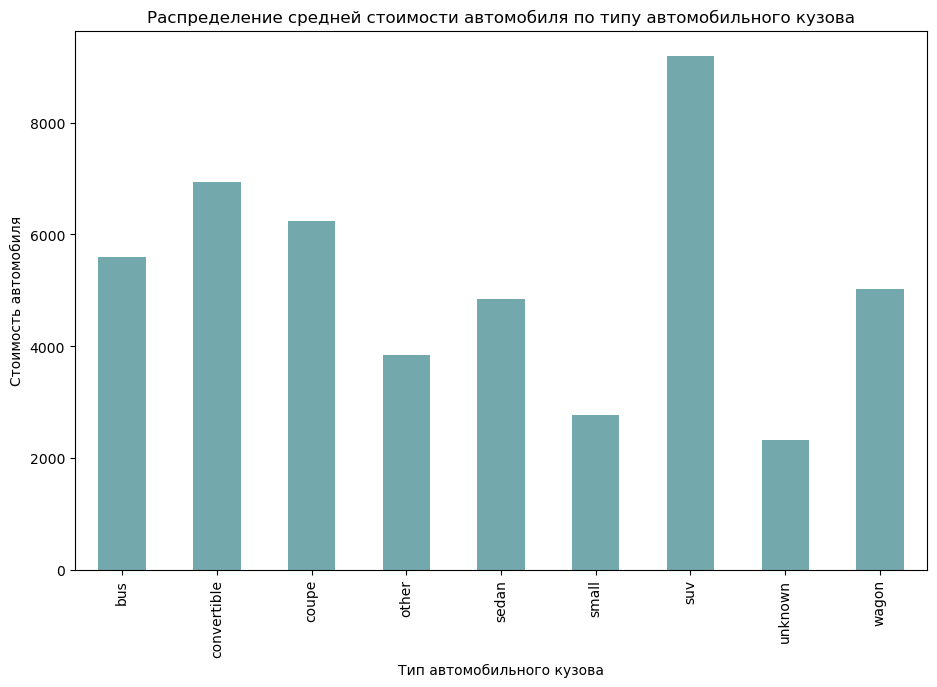

In [19]:
data.groupby('VehicleType')['Price'].mean().plot(kind='bar', figsize=(11, 7), color='#73A9AD')
plt.title('Распределение средней стоимости автомобиля по типу автомобильного кузова')
plt.xlabel('Тип автомобильного кузова')
plt.ylabel('Стоимость автомобиля')

Наибольшая стоимость автомобиля с автомобильным кузовом "suv", 'convertible'. Наименьшая стоимость автомобиля с автомобильным кузовом "small", а также с типом кузова значения, которого пропущено(не указано собственником)


Text(0, 0.5, 'Стоимость автомобиля')

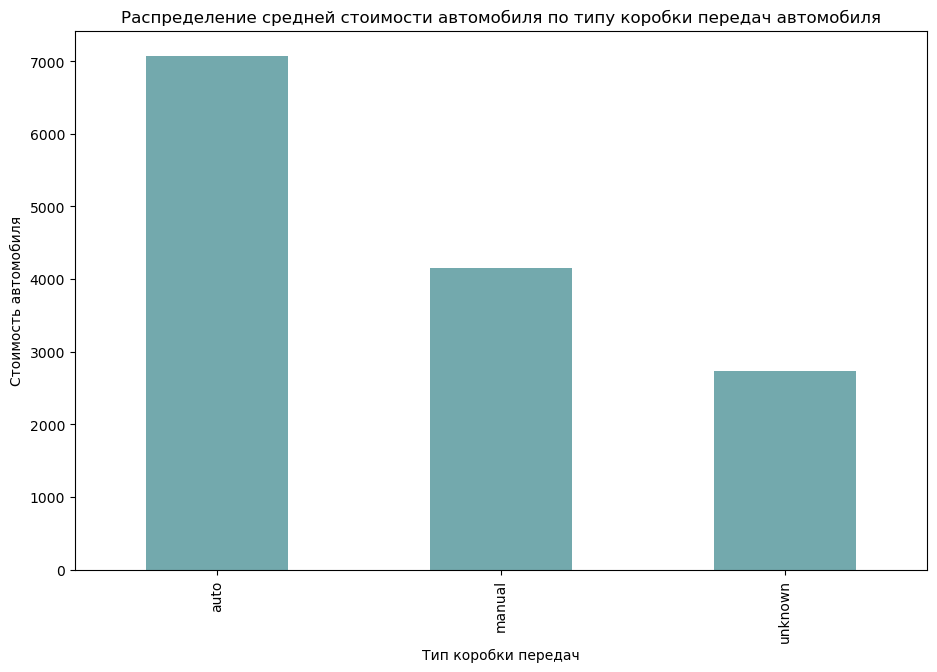

In [20]:
data.groupby('Gearbox')['Price'].mean().plot(kind='bar', figsize=(11, 7), color='#73A9AD')
plt.title('Распределение средней стоимости автомобиля по типу коробки передач автомобиля')
plt.xlabel('Тип коробки передач')
plt.ylabel('Стоимость автомобиля')

Наибольшая стоимость автомобиля с типом коробки передач "auto". Наименьшая стоимость автомобиля с типом кузова "manual", а также с типом коробки передач значения, которого пропущено(не указано собственником)


Text(0, 0.5, 'Стоимость автомобиля')

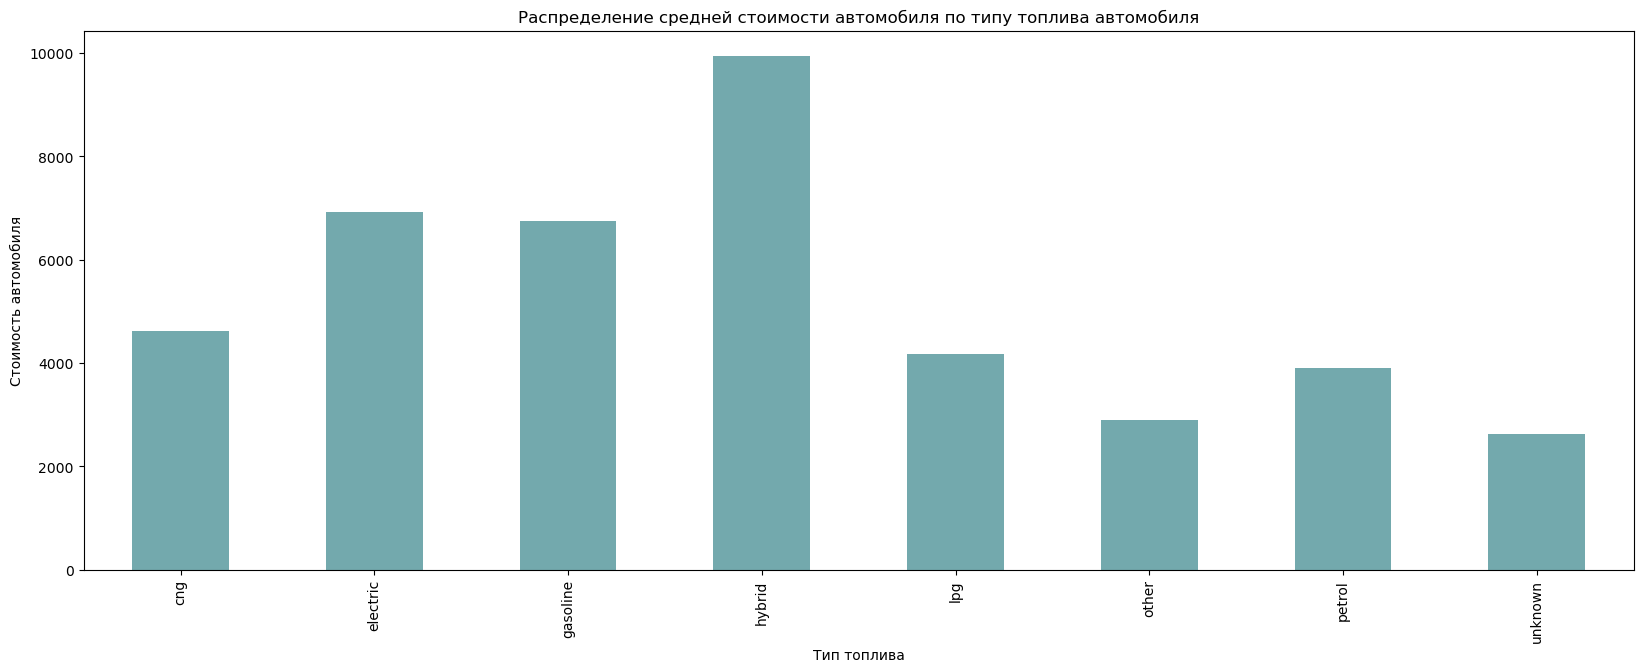

In [21]:
data.groupby('FuelType')['Price'].mean().plot(kind='bar',figsize=(20, 7), color='#73A9AD')
plt.title('Распределение средней стоимости автомобиля по типу топлива автомобиля')
plt.xlabel('Тип топлива')
plt.ylabel('Стоимость автомобиля')

Наибольшая стоимость автомобиля с типом топлива "hybrid", "gasoline". Наименьшая стоимость автомобиля с типом кузова "other", а также с типом топлива значения, которого пропущено(не указано собственником)


Text(0, 0.5, 'Стоимость автомобиля')

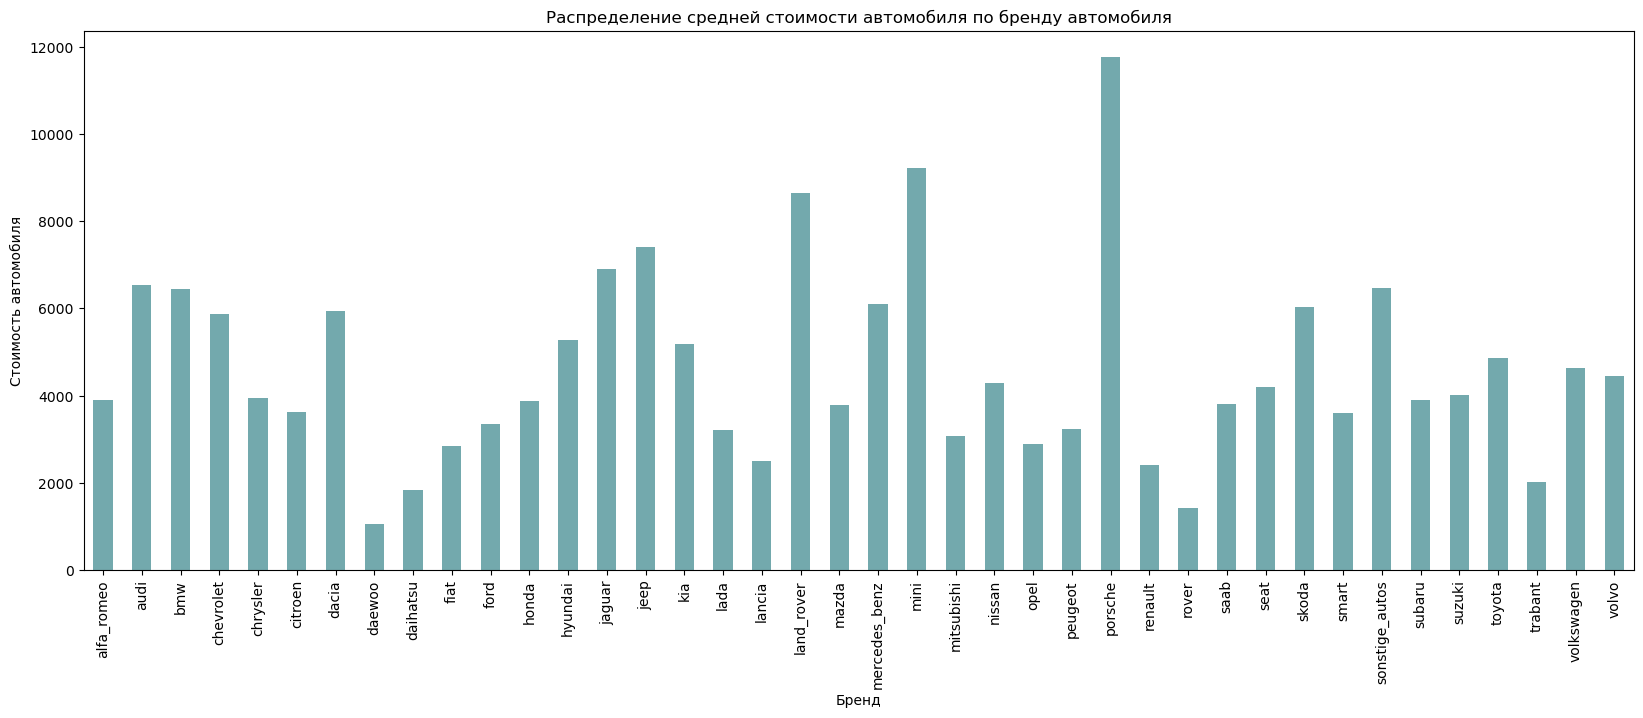

In [22]:
data.groupby('Brand')['Price'].mean().plot(kind='bar',figsize=(20, 7), color='#73A9AD')
plt.title('Распределение средней стоимости автомобиля по бренду автомобиля')
plt.xlabel('Бренд')
plt.ylabel('Стоимость автомобиля')

Наибольшая стоимость автомобиля с брендом "porsche", 'mini', 'mercedes_benz'. Наименьшая стоимость автомобиля с брендом "rover", 'trabant','daewoo'.

Исходя из анализа данных о типе автомобильного кузова, бренда автомобиля, типа топлива, типа коробки передач со средней стоимостью автомобиля. Наибольшая средняя стоимость автомобиля с типом кузова 'suv', 'convertable', типом топлива 'hybrid', 'electric', с автоматической коробкой передач, брендом автомомбиля 'mercedes-benz', 'porche', 'land rover'. Наименьшая стоимость автомобиля с маленьким типом кузова, с типом топлива 'other', 'lpg', 'unknown'(пропуски), с ручной коробкой передач, с брендом 'rover', 'daewoo', 'trabant'


# 1.3 Исследовательский анализ количественных признаков

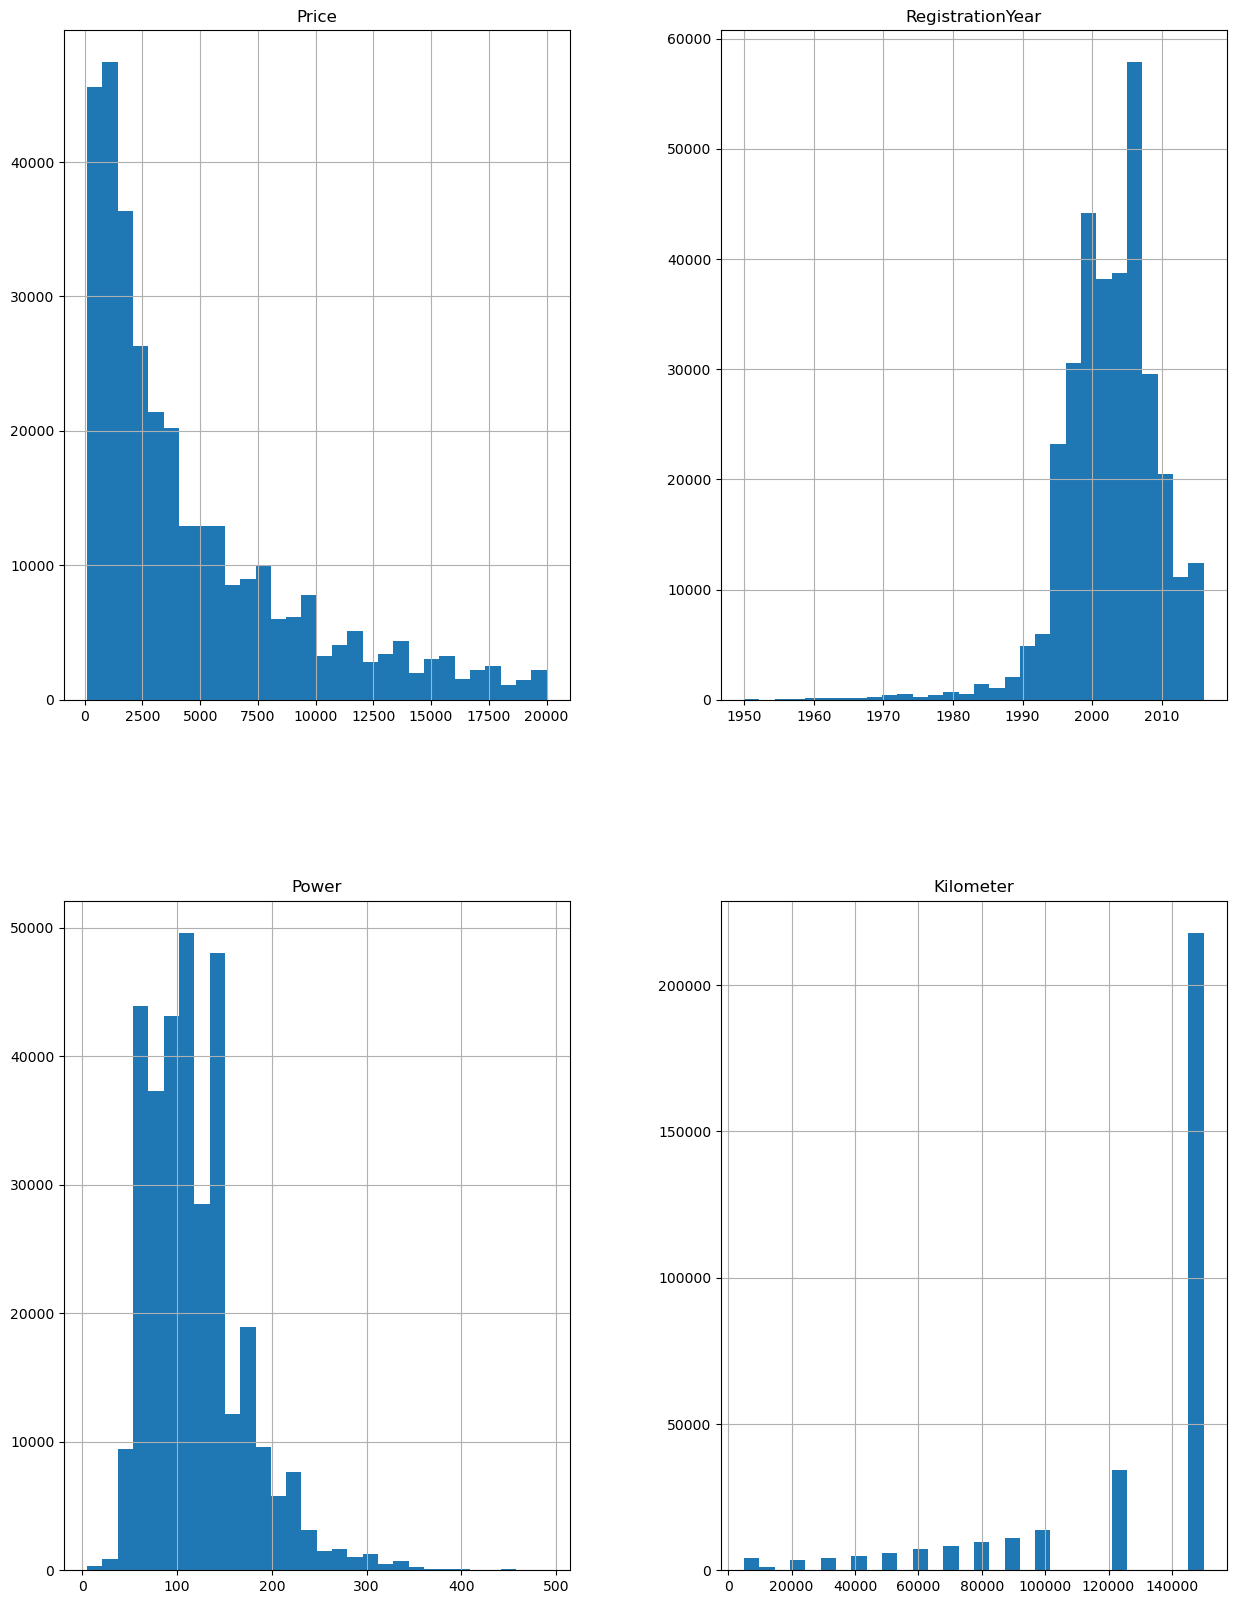

In [23]:
data.hist(figsize=(15, 20), bins=30)
plt.show()

Исходя из данных графиков, наибольшее количество автомобилей со стоимостью до 2500 евро,с годом регистрации с 2000 до 2010, с мощностью от 50 до 180 л.с. и пробегом выше 140 000.

<AxesSubplot:>

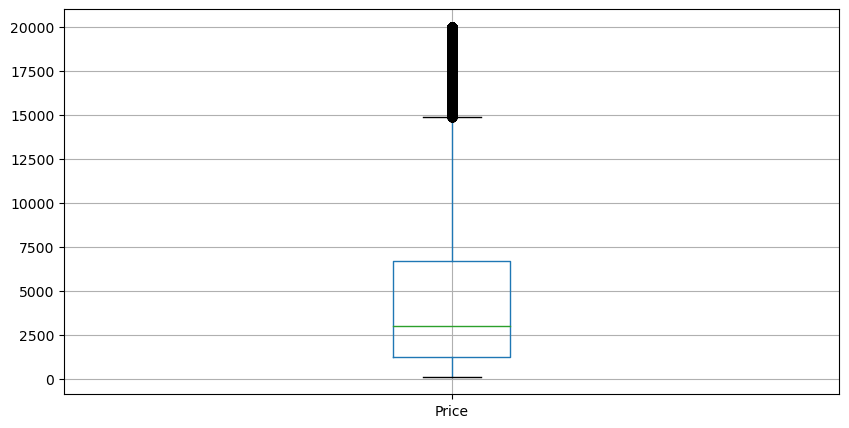

In [24]:
data.boxplot('Price', figsize=(10,5))

<AxesSubplot:>

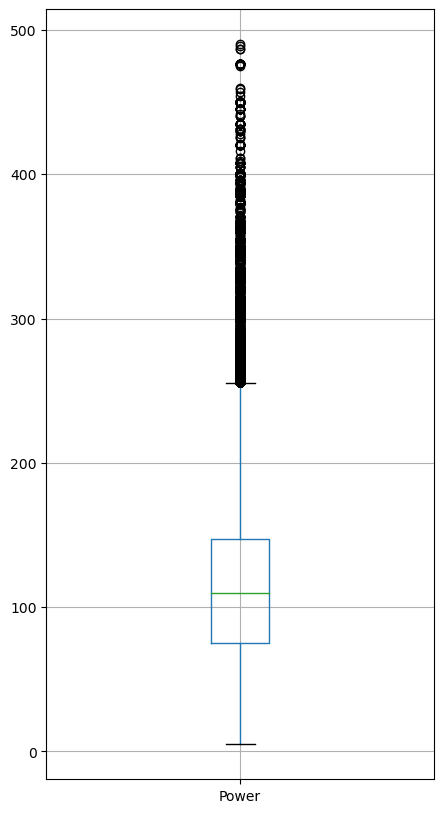

In [25]:
data.boxplot('Power', figsize=(5,10))

<AxesSubplot:>

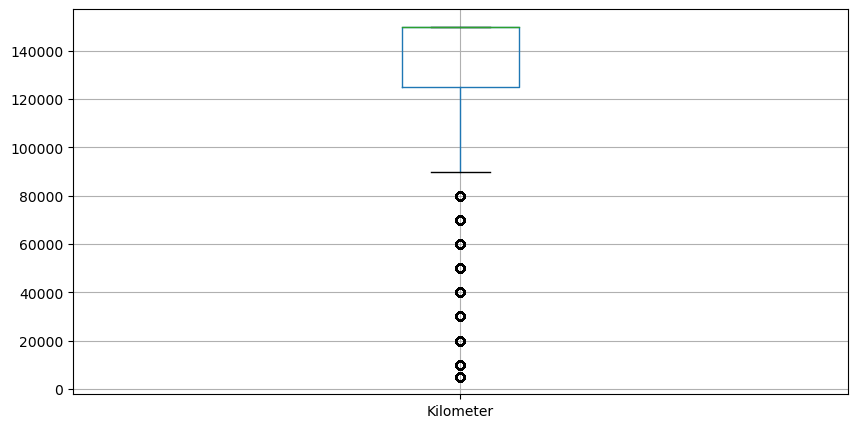

In [26]:
data.boxplot('Kilometer', figsize=(10,5))

In [27]:
#приведение наименований столбцов к нижнему регистру
data.columns = map(str.lower, data.columns)

In [28]:
data.phik_matrix().style.background_gradient(cmap='PuBu')

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer']


,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
price,1.000000,0.281827,0.643606,0.299482,0.516616,0.573301,0.314921,0.267071,0.363040,0.350994
vehicletype,0.281827,1.000000,0.263508,0.503434,0.454620,0.897598,0.245724,0.415532,0.587324,0.412386
registrationyear,0.643606,0.263508,1.000000,0.134984,0.288329,0.613470,0.375640,0.268276,0.385909,0.210741
gearbox,0.299482,0.503434,0.134984,1.000000,0.464533,0.624448,0.055887,0.319878,0.513654,0.431023
power,0.516616,0.454620,0.288329,0.464533,1.000000,0.790547,0.085956,0.243216,0.582611,0.130362
model,0.573301,0.897598,0.613470,0.624448,0.790547,1.000000,0.440353,0.550049,0.997854,0.301279
kilometer,0.314921,0.245724,0.375640,0.055887,0.085956,0.440353,1.000000,0.153323,0.275898,0.226930
fueltype,0.267071,0.415532,0.268276,0.319878,0.243216,0.550049,0.153323,1.000000,0.332151,0.249812
brand,0.363040,0.587324,0.385909,0.513654,0.582611,0.997854,0.275898,0.332151,1.000000,0.145098
repaired,0.350994,0.412386,0.210741,0.431023,0.130362,0.301279,0.226930,0.249812,0.145098,1.000000


Корреляция после обработки аномальных значений Наибольшая корреляция стоимости автомобиля с годом регистрации автомобиля(0.64) и моделью(0.57), мощностью 0.48. Наименьшая корреляция с 0.26 'fueltype' (тип топлива). Изменилась корреляция после удаления аномальных значений

Исходя из данных графиков, наибольшее количество автомобилей со стоимостью до 2500 евро,с годом регистрации с 2000 до 2010, с мощностью от 50 до 180 л.с. и пробегом выше 140 000. Корреляция после обработки аномальных значений Наибольшая корреляция стоимости автомобиля с годом регистрации автомобиля(0.64) и моделью(0.57), мощностью 0.48. Наименьшая корреляция с 0.26 'fueltype' (тип топлива). Изменилась корреляция после удаления аномальных значений

In [29]:
cat_features = ['vehicletype', 'gearbox','model',
       'fueltype', 'brand','repaired']
for c in data[cat_features]:
        data[c] = data[c].astype('category')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325792 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   price             325792 non-null  int64   
 1   vehicletype       325792 non-null  category
 2   registrationyear  325792 non-null  int64   
 3   gearbox           325792 non-null  category
 4   power             325792 non-null  int64   
 5   model             325792 non-null  category
 6   kilometer         325792 non-null  int64   
 7   fueltype          325792 non-null  category
 8   brand             325792 non-null  category
 9   repaired          325792 non-null  category
dtypes: category(6), int64(4)
memory usage: 14.6 MB


## 3.3. Предподготовка данных после деления на выборки

In [32]:
#деление на выборки датасета дата
features = data.drop('price', axis=1)
target = data.price

In [33]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12345)

In [34]:
features_train_st = features_train.copy() 
features_test_st = features_test.copy()

In [36]:
numeric = ['registrationyear','power','kilometer']
scaler = StandardScaler()
scaler.fit(features_train_st[numeric])
features_train_st[numeric] = scaler.transform(features_train_st[numeric])

features_test_st[numeric]  = scaler.transform(features_test_st[numeric])

pd.options.mode.chained_assignment = None

features_train_st.head(5)

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
253075,wagon,0.199623,manual,-0.275648,astra,0.581300,petrol,opel,no
91649,small,0.050499,manual,-1.173943,unknown,0.581300,unknown,opel,unknown
41229,bus,0.199623,manual,-0.849027,combo,0.581300,gasoline,opel,no
235993,wagon,1.690859,manual,-0.332986,caddy,-2.382297,gasoline,volkswagen,no
100999,sedan,-0.545996,manual,-1.173943,micra,-0.092244,petrol,nissan,no


Будет использован тип кодирования OneHotEncoder для категориальных данных


In [37]:
features_train_ohe = pd.get_dummies(features_train_st, drop_first=True)
features_test_ohe = pd.get_dummies(features_test_st, drop_first=True)

In [38]:
features_train_ohe = features_train_ohe.reset_index(drop=True)
features_test_ohe = features_test_ohe.reset_index(drop=True)

In [39]:
features_train_ohe.head(5)

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,0.199623,-0.275648,0.581300,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.050499,-1.173943,0.581300,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.199623,-0.849027,0.581300,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.690859,-0.332986,-2.382297,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,-0.545996,-1.173943,-0.092244,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


После разделения на выборки признаки таблица была разделена на две выборки тренировочная, тестовая. Стандартизированы признаки типом кодирования StandardScaler(), а также обработаны категориальные признаки типом кодирования OHE


# 2. Обучение моделей

Согласно описанию проекта одна из моделей должна быть не бустингом, а среди бустинговых моделей должна быть LGBM. Поэтому в проекте я использую Линейная регрессия, как обучную модель и три бустинговые модели LightGBM, CATBOOST,XGB.


## 2.1.  Линейная регрессия

In [40]:
%%time


model_lin = LinearRegression()
#Обучаю модель
model_lin.fit(features_train_ohe, target_train)
#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = cross_val_score(model_lin,features_train_ohe,target_train,scoring='neg_mean_absolute_error', cv=3)
print('RMSE', abs (regression_cv_score.mean()))

RMSE 1814.868174930316
Wall time: 1min 5s


In [41]:
%%time
lin_pred = model_lin.predict(features_train_ohe)


Wall time: 744 ms


Модель Линейна регрессия показала с применением кодирования для категориальных признаков и стандартизацией количественных признаков результат RMSE 1814.86, временем обучения 65 с., с временем предсказания 0,74 секунд(744 мс)


# 2.2. LightGBM

LightGBM — это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом. Он создан группой исследователей и разработчиков Microsoft. LightGBM известен своей более высокой скоростью обучения, хорошей точностью с параметрами по умолчанию, параллельным и GPU обучением, малым использованием памяти и возможностью обработки больших датасетов, которые не всегда помещаются в ней.

In [42]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244344 entries, 253075 to 236702
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   vehicletype       244344 non-null  category
 1   registrationyear  244344 non-null  int64   
 2   gearbox           244344 non-null  category
 3   power             244344 non-null  int64   
 4   model             244344 non-null  category
 5   kilometer         244344 non-null  int64   
 6   fueltype          244344 non-null  category
 7   brand             244344 non-null  category
 8   repaired          244344 non-null  category
dtypes: category(6), int64(3)
memory usage: 9.1 MB


In [43]:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100,],
        'max_depth' : [5, 7, 10,],
        'verbose' : [-1],
        'random_state' : [1,2,3,4,5],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
    grid_cv.fit(features_train, target_train)
    print('Лучшие гиперпараметры: ', grid_cv.best_params_)
    print('RMSE:: {:.2f} '.format(grid_cv.best_score_* -1))
    return grid_cv.best_params_

In [44]:
%%time
lgb_params = lgb_regr(features_train, target_train)

Лучшие гиперпараметры:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 127, 'random_state': 1, 'verbose': -1}
RMSE:: 1567.55 
Wall time: 4min 20s


In [45]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train)
lgb_pred = model_lgb.predict(features_train)


Wall time: 6.72 s


Модель бустинга LGBM показала результат на тренировочной выборке RMSE 1567.55, с временем обучения 260 секуенд и временем предсказания 6.72 секунд при гиперпараметрах:'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 127, 'random_state': 1, 'verbose': -1


# 2.3 Сatboost

In [46]:
cat_features = ['vehicletype', 'gearbox','model',
       'fueltype', 'brand', 'repaired']

In [47]:
def catboost_regr(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [1, 2, 3, 4, 5],
            'max_depth' : [5, 7, 10]
    }
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
    grid_cv.fit(features_train, target_train, verbose=10, cat_features=cat_features)
    print('Лучшие гиперпараметры: ', grid_cv.best_params_)
    print('RMSE:: {:.2f} '.format(grid_cv.best_score_* -1))
    return grid_cv.best_params_

In [48]:
%%time
catb_params = catboost_regr(features_train, target_train)

Learning rate set to 0.5
0:	learn: 3055.7534690	total: 534ms	remaining: 52.9s
10:	learn: 1741.1939337	total: 3.46s	remaining: 28s
20:	learn: 1658.7470461	total: 6.36s	remaining: 23.9s
30:	learn: 1597.9096767	total: 9.1s	remaining: 20.3s
40:	learn: 1556.9299439	total: 12.4s	remaining: 17.8s
50:	learn: 1529.2243591	total: 15.1s	remaining: 14.5s
60:	learn: 1507.6550592	total: 17.7s	remaining: 11.3s
70:	learn: 1488.5942385	total: 20.5s	remaining: 8.35s
80:	learn: 1471.7312325	total: 23.2s	remaining: 5.44s
90:	learn: 1456.0772151	total: 25.9s	remaining: 2.56s
99:	learn: 1443.2158151	total: 28.3s	remaining: 0us
Лучшие гиперпараметры:  {'max_depth': 10, 'n_estimators': 100, 'random_state': 5, 'verbose': 0}
RMSE:: 1612.94 
Wall time: 18min 14s


In [49]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(features_train, target_train, cat_features=cat_features)
catb_pred = catb_model.predict(features_test)


Wall time: 29.6 s


Модель бустинга CATBOOST показала результат на тренировочной выборке RMSE 1612.94, с временем обучения 1094 сек., временем предсказания 29.6 сек. при гиперпараметрах max_depth': 10, 'n_estimators': 100, 'random_state': 2, 'verbose': 0}


# 3. Анализ моделей

In [50]:
index = ['Линейная регрессия',
         'LightGBM ',
         'CatBoost']
MODEL = {'RMSE на тренировочной выборке':[1814.86,
                1567.55,
                1612.94],
        'Время обучения модели в сек.':[65,
                                 260,
                                 1094],
        
        'Время предсказания модели':[0.74,
                                     6.72,
                                     29.6]
         }
MODEL = pd.DataFrame(data=MODEL, index=index)     

In [51]:
MODEL
MODEL.style\
    .background_gradient(cmap='coolwarm')

,RMSE на тренировочной выборке,Время обучения модели в сек.,Время предсказания модели
Линейная регрессия,1814.860000,65,0.740000
LightGBM,1567.550000,260,6.720000
CatBoost,1612.940000,1094,29.600000


Линейная регрессия RMSE 1814,86 на тренировочной выборке, со временем обучения 65 секунд, временем предсказания 0,74 секунды. LGBM RMSE 1567,55 на тренировочной выборке, со временем обучения 260 секунд, временем предсказания 6,72 секунды СATBOOST RMSE 1649,22 тренировочной выборке, со временем обучения 1094 секунд, временем предсказания 29,6 секунды. Исходя из анализа моделей наилучший результат RMSE у LGBM Boost модели, по времени обучения и предсказания Линейная регрессия. По моему мнению проведено тестирование модели LGBM, так как результат RMSE самый лучший и среднее время обучения и предсказывания, по сравнению с другими моделями.


# 4. Проверка тестовой модели

Самой лучшей себя показала модель LGBM


In [55]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train)
lgb_pred = model_lgb.predict(features_test)
print('RMSE:: {:.2f} '.format(mean_squared_error(target_test, lgb_pred) ** .5))

RMSE:: 1575.25 
Wall time: 5.72 s



На тестовой выборке LGBM показала результат 1575.25 при времени предсказания 5.72 сек.


# 5. Вывод

Данные были представлены в виде таблицы с 14 столбцами, с целевым признаком стоимости автомобиля. Среди столбцов встречались категориальные и количественные признаки. При анализе данных были выявлено, что имеются пропущенные значения в категориальных данных 181077, также было выявлено 4 дубликата. Я заменила пропущенные значения в категориальных признаках на ‘unknown’.Также из таблицы были удалены дубликаты. Неинформативные столбцы с датами, количеством фотографий и почтовым индексом также были удалены. Аномальные значения с годом регистрации были также удалены. Аномальные значения в столбцах с мощностью автомобиля и в таргете. Замена и удаление аномальных значений будет произведена только до деления на выборки.

Также я провела анализ данных среди категориальных и количественных признаков со стоимостью автомобиля. Наибольшая корреляция стоимости автомобиля с годом регистрации автомобиля(0.62). Наибольшая средняя стоимость автомобиля с типом кузова 'suv', 'convertable', типом топлива 'hybrid', 'electric', с автоматической коробкой передач, брендом автомомбиля 'mercedes-benz', 'porche', 'land rover'.

При моделировании были использованы 3 модели: Линейная регрессия, LGBM, Catboost. При этом модели показали себя при обучении следующим образом: Линейная регрессия RMSE 1814,86 на тренировочной выборке, со временем обучения 65 секунд, временем предсказания 0,74 секунды. LGBM RMSE 1567,55 на тренировочной выборке, со временем обучения 260 секунд, временем предсказания 6,72 секунды СATBOOST RMSE 1649,22 тренировочной выборке, со временем обучения 1094 секунд, временем предсказания 32,6 секунды. Исходя из анализа моделей наилучший результат RMSE у LGBM Boost модели, по времени обучения и предсказания Линейная регрессия. По моему мнению проведено тестирование модели LGBM, так как результат RMSE самый лучший и среднее время обучения и предсказывания, по сравнению с другими моделями. Cамой лучшей моделью себя показала LGBM при RMSE 1567.55 время предсказания 6.72 На тестовой выборке LGBM показала результат 1575.25 при времени предсказания 5.72 сек.
